# Detecting the difference between a rock or a mine based on the response of the 60 separate sonar frequencies
---


## The Sonar Data 

### Detecting a Rock or a Mine

Sonar (sound navigation ranging) is a technique that uses sound propagation (usually underwater, as in submarine navigation) to navigate, communicate with or detect objects on or under the surface of the water, such as other vessels.

<img src="sonar.jpg"  style="max-height: 500px; max-width: 500px;">

The data set contains the response metrics for 60 separate sonar frequencies sent out against a known mine field (and known rocks). These frequencies are then labeled with the known object they were beaming the sound at (either a rock or a mine). 

<img src="mine.jpg"  style="max-height: 500px; max-width: 500px;">

My main goal is to create a machine learning model capable of detecting the difference between a rock or a mine based on the response of the 60 separate sonar frequencies.


Data Source: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('sonar.all-data.csv')

In [30]:
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## Data Exploration

**Creating a heatmap of the correlation between the difference frequency responses.**

''

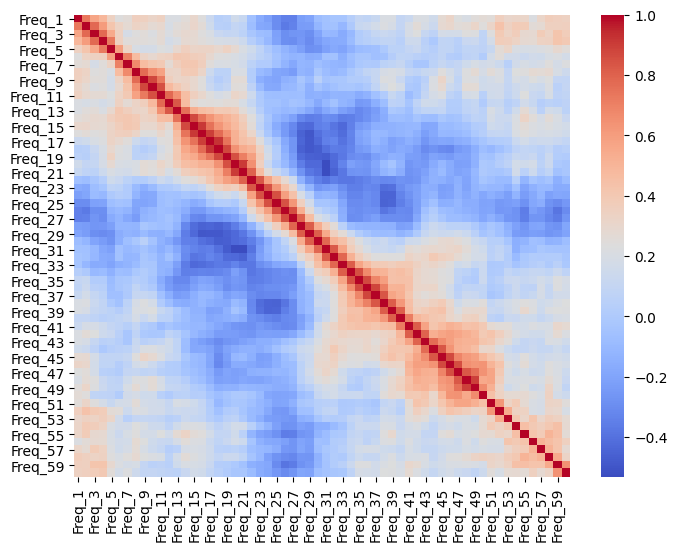

In [4]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(),cmap='coolwarm')
;

**What are the top 5 correlated frequencies with the target\label?**

In [5]:
df['Target'] = df['Label'].map({'R':0,'M':1})

In [6]:
np.abs(df.corr()['Target']).sort_values().tail(6)

Freq_45    0.339406
Freq_10    0.341142
Freq_49    0.351312
Freq_12    0.392245
Freq_11    0.432855
Target     1.000000
Name: Target, dtype: float64

## Train | Test Split

**My approach here will be: using Cross Validation on 90% of the dataset, and then judging our results on a final test set of 10% to evaluate the model.**

In [7]:
from sklearn.model_selection import train_test_split 

In [8]:
X = df.drop(['Target','Label'],axis=1)
y = df['Label']

In [9]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**Creating a PipeLine that contains both a StandardScaler and a KNN model**

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [11]:
scaler = StandardScaler()

In [12]:
knn = KNeighborsClassifier()

In [13]:
operations = [('scaler',scaler),('knn',knn)]

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
pipe = Pipeline(operations)

**Performing a grid-search with the pipeline to test various values of k and report back the best performing parameters.**

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
k_values = list(range(1,30))

In [18]:
param_grid = {'knn__n_neighbors': k_values}

In [19]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [20]:
full_cv_classifier.fit(X_cv,y_cv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [21]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

**Using the .cv_results_ dictionary, to see if I can create a plot of the mean test scores per K value.**

In [22]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.84537696, 0.78065434, 0.77524893, 0.75917496, 0.75931721,
       0.74822191, 0.75945946, 0.71664296, 0.7113798 , 0.68421053,
       0.70042674, 0.68435277, 0.68449502, 0.67908962, 0.69530583,
       0.68990043, 0.7113798 , 0.70042674, 0.72204836, 0.67908962,
       0.70071124, 0.69530583, 0.69530583, 0.68463727, 0.68477952,
       0.67923186, 0.67411095, 0.65775249, 0.6685633 ])

''

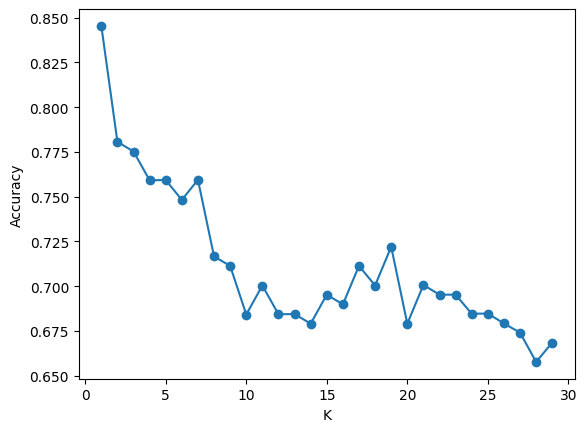

In [23]:
scores = full_cv_classifier.cv_results_['mean_test_score']
plt.plot(k_values,scores,'o-')
plt.xlabel("K")
plt.ylabel("Accuracy")
;

### Final Model Evaluation

**Using the grid classifier object from the previous step, to get a final performance classification report and confusion matrix.**

In [24]:
pred = full_cv_classifier.predict(X_test)

In [25]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [26]:
confusion_matrix(y_test,pred)

array([[12,  1],
       [ 1,  7]], dtype=int64)

In [27]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           M       0.92      0.92      0.92        13
           R       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



# THE END